In [ ]:
import numpy as np, matplotlib.pyplot as plt, glob
from scipy.optimize import curve_fit
import subprocess
import sys, os
import pickle as pkl

import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

In [ ]:

seq_dir = '../11bp_varyT_s-0.01_bf-4_ns-1e+09/' 
save_dir = 'FES_outs/'
n_bp = 11

# just specify manually for abasics 
base_list = [0, 2, 4, 6]
seq_list = ['CCTATATATCC','CGCATATATAT','TATAGCGATAT','TTTTTTTTTTT',]

# for determining H vs. D regions
hbr_cutoff = 2
diss_max = 7.5

# limits
sig_min = 280
sig_max = 360

In [ ]:
# calculate fes averaged over last N timesteps to diminish noise

rmin, rmax = 15, 20
fes_range = np.arange(rmin, rmax+1)
avg_name = f'fes_{rmin}_{rmax}_avg.npy'

all_fes_dirs = glob.glob(f'{seq_dir}/*')
print(fes_range)

for fes_dir in all_fes_dirs:
    FES_list = []
    for i in fes_range:
        temp_fes = f'{fes_dir}/fes_{i}.dat'
        print(temp_fes)
        with open(temp_fes, 'r') as f:
            FES_data = []
            lines = f.readlines()
            for i in range(5, len(lines)):
                FES_data.append([float(idx) for idx in lines[i].split()])
            FES_data = np.array(FES_data)
            FES_list.append(FES_data)    
        f.close()
        
    FES_list = np.array(FES_list) 
    FES_avg = np.mean(FES_list, axis=0)
    np.save(f'{fes_dir}/{avg_name}', FES_avg)
    print(fes_dir, FES_avg.shape, np.mean(FES_avg))


Text(0, 0.5, '                                                  Free energy (kJ/mol)')

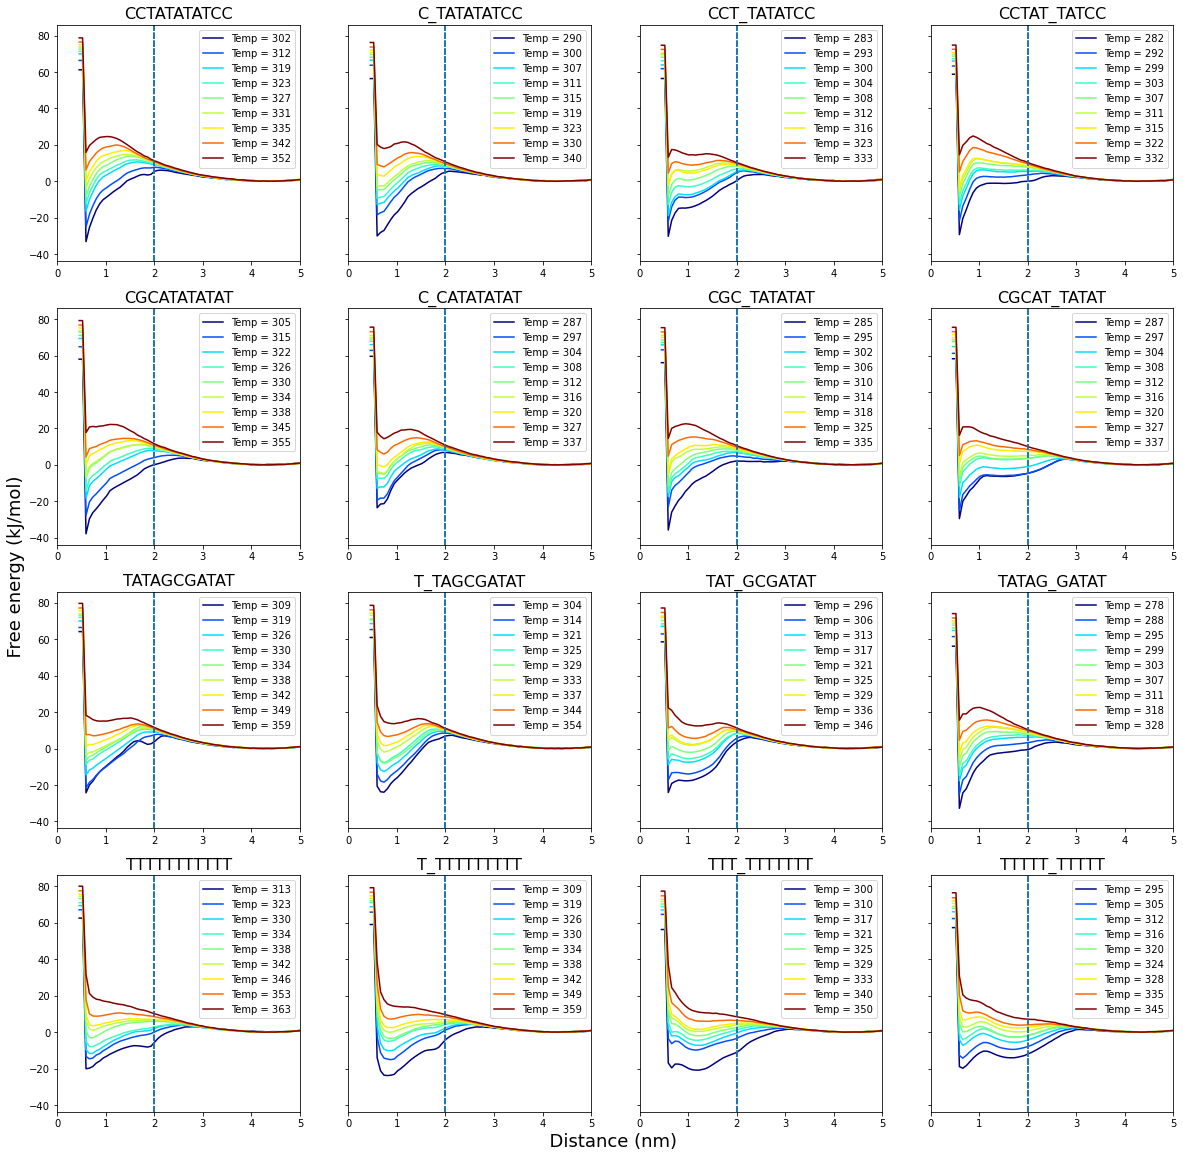

In [4]:
### Plot temp-depedent FES and melting curves

plot_type = 'fe' # 'fe' shows all free energy surfarces, 'prob' shows probabilities
fes = 'fes_20.dat'
window = 1

save_txt = False
subtract_diss = True
use_avg_fes = True
fluct_correction= True
save_txt_path = './Brennan_FES_temps/'
avg_name = 'fes_15_20_avg.npy'

kB = 1.380 * 6.022 / 1000 #kJ/mol/K
seq_hbr_list = []

fig, axes = plt.subplots(len(seq_list), len(base_list), 
                         figsize=(5*len(base_list), 5*len(seq_list)), sharey=True)

# fit melting curve to simple sigmoid
def sigmoid(x, a, b):
    return 1 - 1/ (1 + np.exp(b*(a - x)))

# record difference in theoretical and predicted tm 
tm_fit_list = []
popt_list = []

for ax_row, seq in zip(axes, seq_list):
    for ax, base in zip(ax_row, base_list):
        
        # get temps for each seq and base combination
        temp_dirs = sorted(glob.glob(f'{seq_dir}{seq}_base-{base}*'))
        plot_temps = [int(td[-3:]) for td in temp_dirs]
        FES_list = []
        
        # normalize color map with temp
        normalize = mcolors.Normalize(
            vmin=np.min(plot_temps), vmax=np.max(plot_temps))
        colormap = cm.jet
        
        if base==0: abasic_label= seq
        else:       abasic_label= f'{seq[:base-1]}_{seq[base:]}'
        
        for temp, t_dir in zip(plot_temps, temp_dirs):
            if use_avg_fes:
                FES_data = np.load(f'{t_dir}/{avg_name}')
        
            else:
                # open fes file and convert to npy 
                temp_fes = f'{t_dir}/{fes}'
                with open(temp_fes, 'r') as f:
                    FES_data = []
                    lines = f.readlines()
                    for i in range(5, len(lines)):
                        FES_data.append([float(idx) for idx in lines[i].split()])
                    FES_data = np.array(FES_data)
                f.close()
                
            FES_list.append(FES_data)

        #FES_list = np.load(f'{save_dir}{seq}-base-{base}_{fes}_{fes_label}.npy')
        #temp_list = np.load(f'{save_dir}{seq}-base-{base}_temp_{fes_label}.npy')
        hbr_list = []

        # evaluate each FES at each temperature
        for i, (FES_data, temp1) in enumerate(zip(FES_list, plot_temps)):

            # make sure FES_DATA properly loaded
            #print(seq, base, temp1, np.shape(FES_data))

            cv = FES_data[:, 0]
            fe = FES_data[:, 1]

            # convert to probability
            p = np.exp(-fe/(temp1*kB))
            p = p/np.sum(p)

            # calculate percent hybridized vs. dissociated over time
            hbr_idx = int(len(cv)*(hbr_cutoff - np.min(cv)) /(np.max(cv)-np.min(cv)))
            diss_idx = int(len(cv)*(diss_max - np.min(cv)) /(np.max(cv)-np.min(cv)))
            phi = np.sum(p[:hbr_idx]) / np.sum(p[hbr_idx:diss_idx]) 

            # apply fluctuation correction
            if fluct_correction:
                perc_hbr = 1+1/(2*phi) - np.sqrt((1+1/(2*phi))**2 - 1)
            else:
                perc_hbr = np.sum(p[:hbr_idx]) / np.sum(p[:diss_idx])
            hbr_list.append(perc_hbr)

            if plot_type == 'fe':
                if subtract_diss: fe = fe - min(fe[40:])
                ax.plot(cv, fe, label=f'Temp = {temp1}', color=colormap(normalize(temp1)))
                ax.set_title(abasic_label, fontsize=16)
                ax.set_xlim(0, 5)

                # plot hybrid and dissociation cutoffs
                ax.axvline(hbr_cutoff, linestyle='dashed')
                ax.axvline(diss_max, linestyle='dashed')
                ax.set_xlim(0, 5)
                ax.legend()
                
                # save to output files
                if save_txt:
                    with open(f'{save_txt_path}bins.txt', 'w') as f:
                        cv_str = [str(x) for x in cv]
                        f.writelines('\n'.join(cv_str))
                    with open(f'{save_txt_path}{seq}_base-{base}_temp-{temp1}.txt', 'w') as f:
                        fe_str = [str(x) for x in fe]
                        f.writelines('\n'.join(fe_str))
                
            elif plot_type == 'prob':
                ax.plot(cv, p, label=f'Temp = {temp1}', color=colormap(normalize(temp1)))
                ax.set_title(abasic_label, fontsize=16)

        seq_hbr_list.append(hbr_list)

        # setup the colorbar
        scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
        scalarmappaple.set_array(np.arange(290, 338))
        #plt.colorbar(scalarmappaple)

spaces = ' '*50
axes[-1, 1].set_xlabel(f'{spaces}Distance (nm)', fontsize=18)
axes[2, 0].set_ylabel(f'{spaces}Free energy (kJ/mol)', fontsize=18)

In [11]:
def extend_fes(fe, cv, temp, e_i=45, d_target=7.34):
    '''Analytically extend the FES where:
        e_i bin index corresponding to the edge of the simulated surface
        d is seperation beyond the edge'''
    
    fe_ext = fe[e_i] + 2*kB*temp*np.log(cv[e_i]) - 2*kB*temp*np.log(cv[e_i:])
    fe_comb = np.append(fe[:e_i], fe_ext)
    return fe_comb

Na = 6.02214e23
boxL = 8.5514e-9   # m
target_conc = 2.0  #mM

# radius of a sphere with target conc
pbc_conc = 2/(boxL**3)/Na      #mM
d_current = (3*2/(4*np.pi*pbc_conc*Na))**(1/3) * 1e9
d_target = (3*2/(4*np.pi*target_conc*Na))**(1/3) * 1e9
print(pbc_conc, d_current, d_target)

5.310892169276025 5.304865187877136 7.346043815599719


Text(0, 0.5, '                                                  Dimer Fraction')

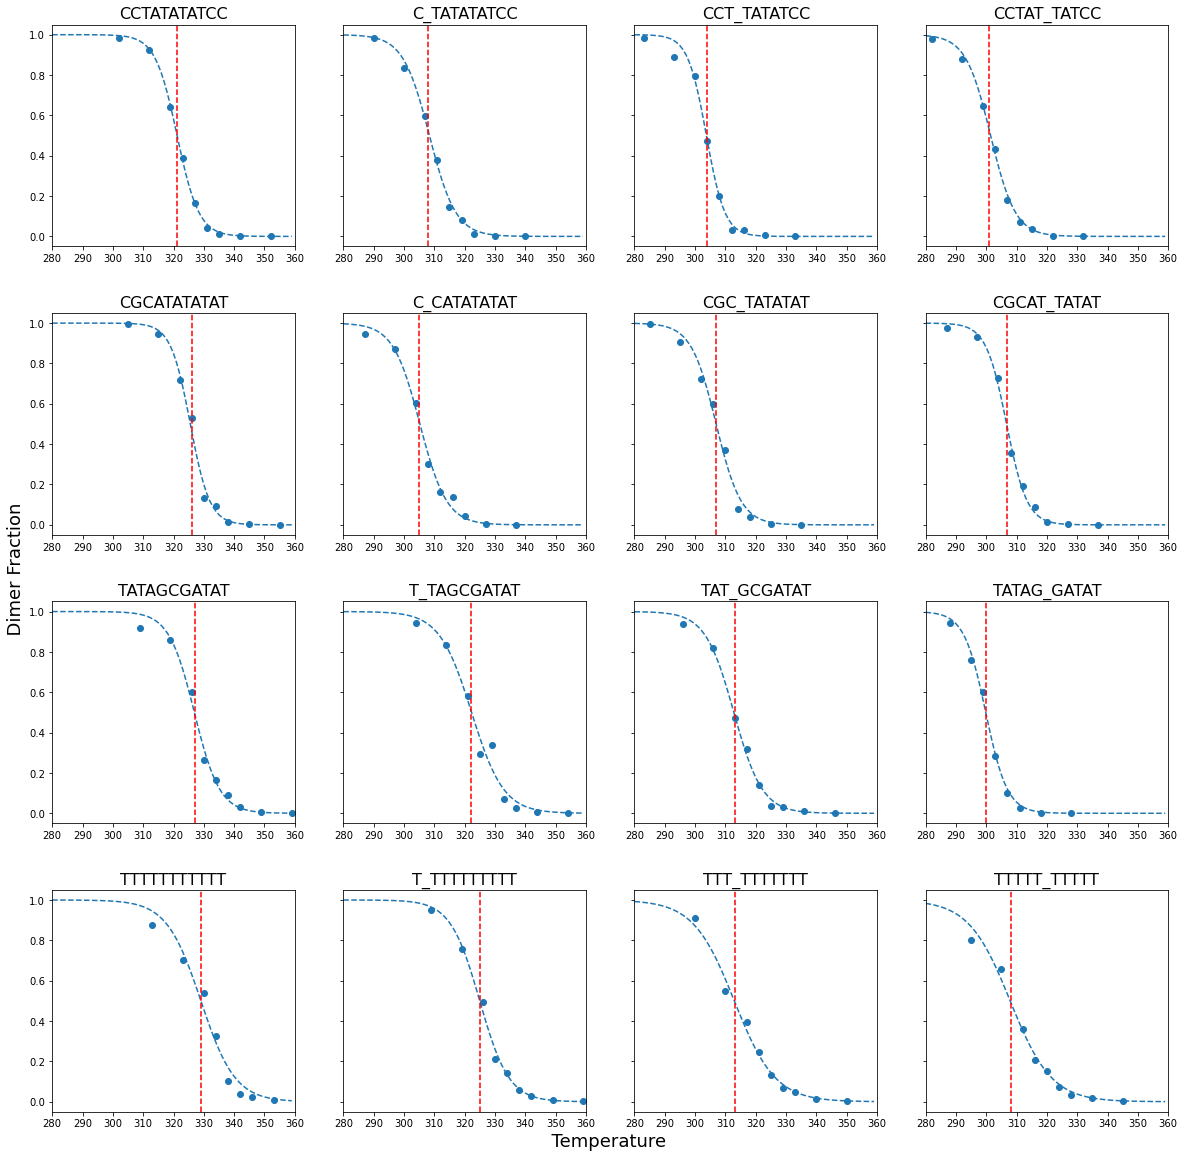

In [12]:
### Plot and melting curves

save_txt_path = './Brennan_FES_temps/melting_curves_extended/'
avg_name = 'fes_15_20_avg.npy'
save_txt = True

kB = 1.380 * 6.022 / 1000 #kJ/mol/K
seq_hbr_list = []

fig, axes = plt.subplots(len(seq_list), len(base_list), 
                         figsize=(5*len(base_list), 5*len(seq_list)), sharey=True)

# record difference in theoretical and predicted tm 
tm_fit_list = []
popt_list = []

for ax_row, seq in zip(axes, seq_list):
    for ax, base in zip(ax_row, base_list):
        
        # get temps for each seq and base combination
        temp_dirs = sorted(glob.glob(f'{seq_dir}{seq}_base-{base}*'))
        plot_temps = [int(td[-3:]) for td in temp_dirs]
        FES_list = []
        
        # normalize color map with temp
        normalize = mcolors.Normalize(
            vmin=np.min(plot_temps), vmax=np.max(plot_temps))
        colormap = cm.jet
        
        if base==0: abasic_label= seq
        else:       abasic_label= f'{seq[:base-1]}_{seq[base:]}'
        
        for temp, t_dir in zip(plot_temps, temp_dirs):
            if use_avg_fes:
                FES_data = np.load(f'{t_dir}/{avg_name}')
        
            else:
                # open fes file and convert to npy 
                temp_fes = f'{t_dir}/{fes}'
                with open(temp_fes, 'r') as f:
                    FES_data = []
                    lines = f.readlines()
                    for i in range(5, len(lines)):
                        FES_data.append([float(idx) for idx in lines[i].split()])
                    FES_data = np.array(FES_data)
                f.close()
                
            FES_list.append(FES_data)

        #FES_list = np.load(f'{save_dir}{seq}-base-{base}_{fes}_{fes_label}.npy')
        #temp_list = np.load(f'{save_dir}{seq}-base-{base}_temp_{fes_label}.npy')
        hbr_list = []

        # evaluate each FES at each temperature
        for i, (FES_data, temp1) in enumerate(zip(FES_list, plot_temps)):

            # make sure FES_DATA properly loaded
            #print(seq, base, temp1, np.shape(FES_data))

            cv = FES_data[:, 0]
            fe = FES_data[:, 1]
            fe = extend_fes(fe, cv, temp) # extend to 2mM concentration

            # convert to probability
            p = np.exp(-fe/(temp1*kB))
            p = p/np.sum(p)

            # calculate percent hybridized vs. dissociated over time
            hbr_idx = int(len(cv)*(hbr_cutoff - np.min(cv)) /(np.max(cv)-np.min(cv)))
            diss_idx = int(len(cv)*(diss_max - np.min(cv)) /(np.max(cv)-np.min(cv)))
            phi = np.sum(p[:hbr_idx]) / np.sum(p[hbr_idx:diss_idx]) 

            # apply fluctuation correction
            if fluct_correction:
                perc_hbr = 1+1/(2*phi) - np.sqrt((1+1/(2*phi))**2 - 1)
            else:
                perc_hbr = np.sum(p[:hbr_idx]) / np.sum(p[:diss_idx])
            hbr_list.append(perc_hbr)

        seq_hbr_list.append(hbr_list)

        # setup the colorbar
        scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
        scalarmappaple.set_array(np.arange(290, 338))
        #plt.colorbar(scalarmappaple)

        avg_list = []
        for i in range(window, len(hbr_list)-window):
            avg = np.mean(hbr_list[i-window:i+window])
            avg_list.append(avg)

        # fit curve to sigmoid
        popt, pcov = curve_fit(sigmoid, plot_temps, hbr_list, bounds=([280., 0.1], [380., 0.5]))
        xdata = np.arange(sig_min, sig_max)  #np.arange(min(plot_temps) - 5, max(plot_temps)+5)
        ydata = sigmoid(xdata, popt[0], popt[1])

        # find nearest melting temp:
        tm_fit  = xdata[np.argmin(np.abs(ydata-0.5))]
        tm_fit_list.append(tm_fit)
        popt_list.append(popt)

        # plot data and fit
        ax.scatter(plot_temps, hbr_list)
        ax.plot(xdata, ydata, linestyle='dashed')
        ax.axvline(tm_fit, 0, 1, linestyle='dashed', c='red')

        ax.set_title(abasic_label, fontsize=16)
        plt.subplots_adjust(hspace=0.3)
        ax.set_xlim(sig_min, sig_max)
        
        if save_txt:
            with open(f'{save_txt_path}{seq}_base-{base}_temps.txt', 'w') as f:
                melt_str = [str(x) for x in plot_temps]
                f.writelines('\n'.join(melt_str))
            with open(f'{save_txt_path}{seq}_base-{base}_dimer.txt', 'w') as f:
                hbr_str = [str(x) for x in hbr_list]
                f.writelines('\n'.join(hbr_str))
            

spaces = ' '*50
axes[-1, 1].set_xlabel(f'{spaces}Temperature', fontsize=18)
axes[2, 0].set_ylabel(f'{spaces}Dimer Fraction', fontsize=18)

5.310892169276025 5.304865187877136 7.346043815599719
45 0.1264865242443456 0.12228933517161789 0.04864745288372241


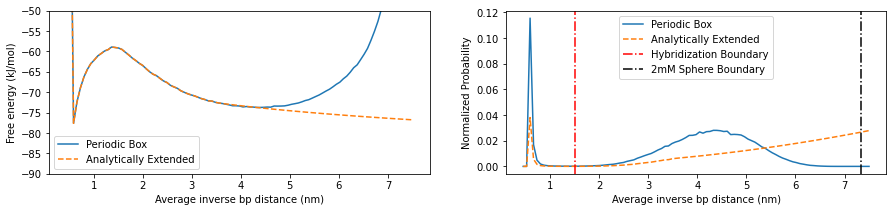

In [8]:
# example of extending out analytically for SI

Na = 6.02214e23
boxL = 8.5514e-9      # m
target_conc = 2.0  #mM

# radius of a sphere with target conc
pbc_conc = 2/(boxL**3)/Na      #mM
d_current = (3*2/(4*np.pi*pbc_conc*Na))**(1/3) * 1e9
d_target = (3*2/(4*np.pi*target_conc*Na))**(1/3) * 1e9
print(pbc_conc, d_current, d_target)

# get Tm test data for a given sequence
temp = 331
t_dir = glob.glob(f'{seq_dir}/CCTAT*_base-0*{temp}*')[0]
FES_data = np.load(f'{t_dir}/{avg_name}')
cv = FES_data[:, 0]
fe = FES_data[:, 1]


def extend_fes(fe, cv, temp, e_i, d_target=7.34):
    '''Analytically extend the FES where:
        e_i bin index corresponding to the edge of the simulated surface
        d is seperation beyond the edge'''
    
    fe_ext = fe[e_i] + 2*kB*temp*np.log(cv[e_i]) - 2*kB*temp*np.log(cv[e_i:])
    fe_comb = np.append(fe[:e_i], fe_ext)
    return fe_comb

def prob(fe, temp):
    p = np.exp(-fe/(temp*kB))
    p = p/np.sum(p)
    return p

def dimer_fract(p, cv, hbr, dis=7.5):
    
    hbr_idx = np.argmin(np.abs(cv-hbr))
    dis_idx = np.argmin(np.abs(cv-dis))
    phi = np.sum(p[:hbr_idx]) / np.sum(p[hbr_idx:dis_idx]) 
    perc_hbr = 1+1/(2*phi) - np.sqrt((1+1/(2*phi))**2 - 1)
    return perc_hbr

hbr = 1.5
e_i = 45
p = prob(fe, temp)
perc_box = dimer_fract(p, cv, hbr)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].plot(cv, fe, label='Periodic Box')
axes[1].plot(cv, prob(fe, temp), label='Periodic Box')
axes[0].set_ylim(-90, -50)

fe_ext = extend_fes(fe, cv, temp, e_i)
p_ext = prob(fe_ext, temp)
perc_sphere_small = dimer_fract(p_ext, cv, hbr, dis=d_current)
perc_sphere_large = dimer_fract(p_ext, cv, hbr, dis=d_target)

axes[0].plot(cv, fe_ext, linestyle='dashed', label='Analytically Extended')
axes[1].plot(cv, p_ext, linestyle='dashed', label='Analytically Extended')

print(e_i, perc_box, perc_sphere_small, perc_sphere_large)
    
axes[0].set_ylabel('Free energy (kJ/mol)')
axes[0].set_xlabel('Average inverse bp distance (nm)')
axes[0].legend()

axes[1].axvline(hbr, color='red', label='Hybridization Boundary', linestyle='dashdot')
axes[1].axvline(d_target, color='black', label='2mM Sphere Boundary', linestyle='dashdot')

axes[1].set_ylabel('Normalized Probability')
axes[1].set_xlabel('Average inverse bp distance (nm)')
axes[1].legend()